# Gate Cutting to Reduce Circuit Depth

In this tutorial, we will simulate some expectation values on a circuit of a certain depth by cutting gates resulting in swap gates and executing subexperiments on shallower circuits.

Like any circuit knitting technique, gate cutting can be described as three consecutive steps:
 - **decompose** some non-local gates in the circuit and possibly separate the circuit into subcircuits
 - **execute** many sampled subexperiments on the backend(s)
 - **reconstruct** the simulated expectation value of the full-sized circuit

In [1]:
import numpy as np
from qiskit import transpile
from qiskit.circuit.library import EfficientSU2
from qiskit_aer.primitives import Estimator, Sampler
from qiskit.providers.fake_provider import FakeHanoiV2 as FakeHanoi
from qiskit.quantum_info import PauliList

from circuit_knitting_toolbox.circuit_cutting import (
    decompose_gates,
    execute_experiments,
    reconstruct_expectation_values,
)

### Create a circuit to run on the backend

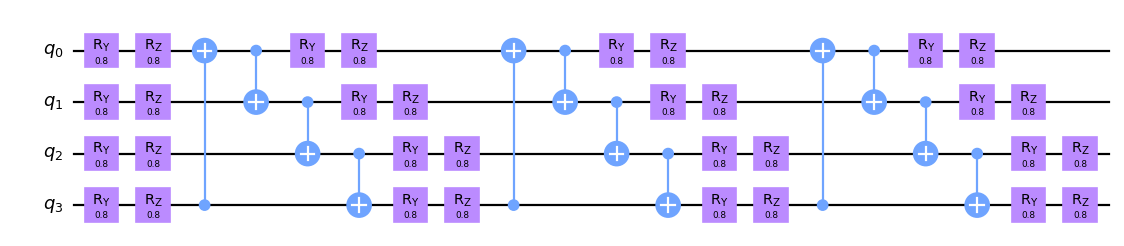

In [2]:
circuit = EfficientSU2(num_qubits=4, entanglement="circular").decompose()
circuit.assign_parameters([0.8] * len(circuit.parameters), inplace=True)
circuit.draw("mpl", scale=0.8)

### Specify some observables

Currently, only `Pauli` observables with phase equal to 1 are supported. Full support for `SparsePauliOp` is expected in CKT v0.3.0.

In [3]:
observables = PauliList(["ZZII", "IZZI", "IIZZ", "XIXI", "ZIZZ", "IXIX"])

### Transpile the circuit, visualize the swaps, and note the depth

We choose a layout that requires two swaps to execute the gates between qubits 3 and 0 and another two swaps to return the qubits to their initial positions.

In [4]:
backend = FakeHanoi()

transpiled_qc = transpile(circuit, backend=backend, initial_layout=[0, 1, 2, 3])
print(f"Transpiled circuit depth: {transpiled_qc.depth()}")

Transpiled circuit depth: 63


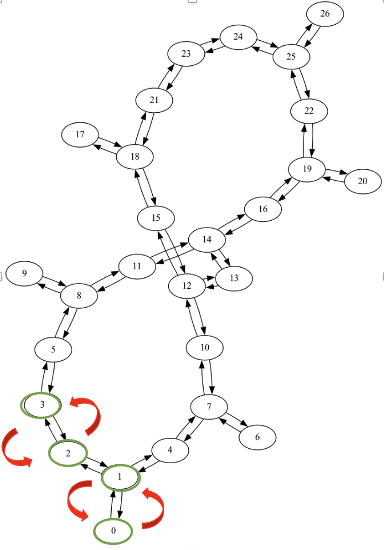

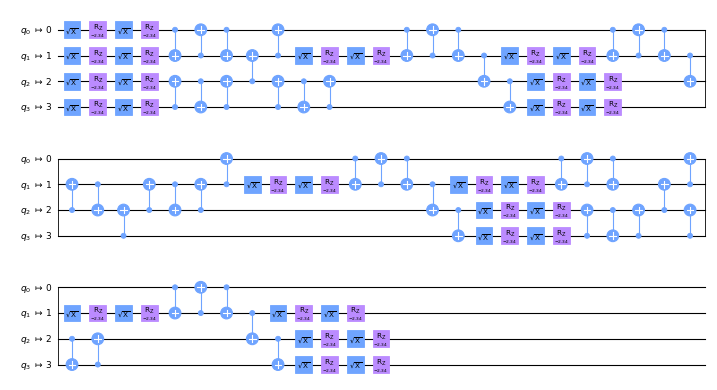

In [5]:
transpiled_qc.draw("mpl", scale=0.4, idle_wires=False)

### Replace distant gates with `TwoQubitQPDGate`s by specifying their indices

`decompose_gates` will replace the gates in the specified indices with `TwoQubitQPDGate`s and also return a list of `QPDBasis` instances -- one for each gate decomposition.

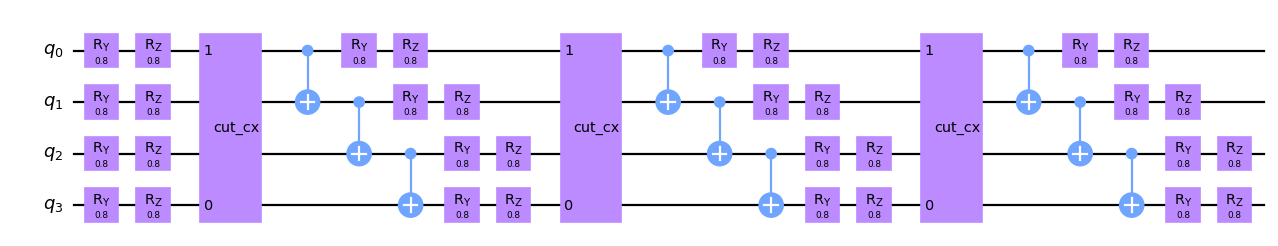

In [6]:
# Find the indices of the distant gates
cut_indices = [
    i
    for i, instruction in enumerate(circuit.data)
    if {circuit.find_bit(q)[0] for q in instruction.qubits} == {0, 3}
]

# Decompose distant CNOTs into TwoQubitQPDGate instances
qpd_circuit, bases = decompose_gates(circuit, cut_indices)
qpd_circuit.draw("mpl", scale=0.8)

### Calculate the sampling overhead for the chosen cuts

In [7]:
print(f"Sampling overhead: {np.prod([basis.overhead for basis in bases])}")

Sampling overhead: 729.0


### Demonstrate that the QPD subexperiments will be shallower after cutting distant gates

Here is an example of an arbitrarily chosen subexperiment generated from the QPD circuit. Its depth has been reduced by more than half. Many of these probabilistic subexperiments must be generated and evaluated in order to reconstruct a simulated expectation value of the deeper circuit.

Original circuit depth after transpile: 63
QPD subexperiment depth after transpile: 23


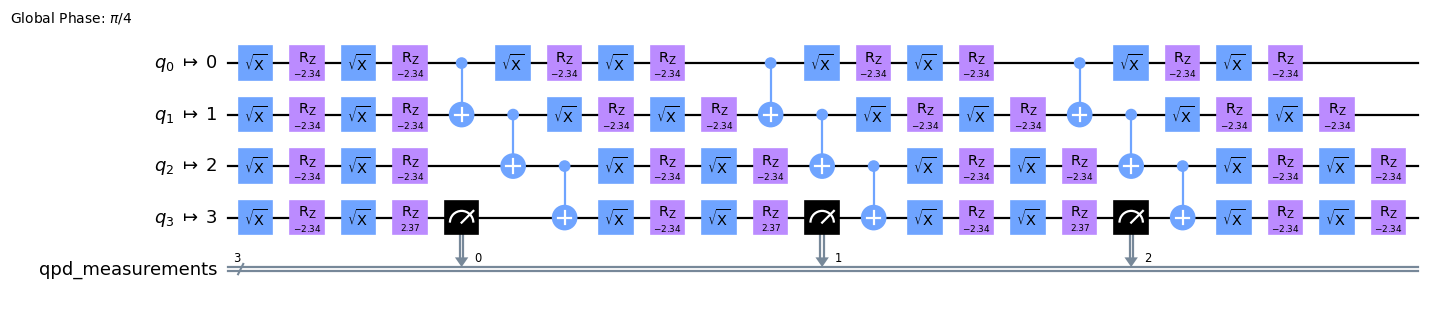

In [8]:
from circuit_knitting_toolbox.circuit_cutting.qpd import decompose_qpd_instructions

# Set some arbitrary bases to which the QPD gates should decompose
for idx in cut_indices:
    qpd_circuit[idx].operation.basis_id = 2

# Decompose QPDGates in a circuit into Qiskit operations and measurements
qpd_circuit_dx = decompose_qpd_instructions(qpd_circuit, [[idx] for idx in cut_indices])

# Transpile the decomposed circuit to the same layout
transpiled_qpd_circuit = transpile(
    qpd_circuit_dx, backend=backend, initial_layout=[0, 1, 2, 3]
)

print(f"Original circuit depth after transpile: {transpiled_qc.depth()}")
print(f"QPD subexperiment depth after transpile: {transpiled_qpd_circuit.depth()}")
transpiled_qpd_circuit.draw("mpl", scale=0.8, idle_wires=False)

### Generate and run the subexperiments

`execute_experiments` accepts a circuit containing `TwoQubitQPDGate`s as its `circuits` argument. If a single circuit is passed in this way, a `PauliList` is the expected type of the `subobservables` argument. 

Much of the circuit cutting literature describes a process where we sample from the distribution, take a single shot, sample from the distribution again and repeat; however, this is not feasible in practice. The number of shots needed grows exponentially with the number of cuts, and single shot experiments via Qiskit Runtime quickly become untenable. Instead, we take an equivalent number of shots for each sampled subexperiment, and send them to the backend(s) in batches. We just need to ensure the number of shots we take is appropriate for the heaviest-weighted samples, and thus, appropriate for all samples.

To simulate the expectation value of the full-sized circuit, many subexperiments are generated from the decomposed gates' joint quasiprobability distribution and then executed on one or more backends. The number of samples taken from the distribution is controlled by `num_samples`. If the smallest sample probability in the joint quasi-probability distribution is above 1 / `num_samples`, exact weights will be used.  Otherwise, the weights will be sampled, resulting in at most `num_samples` unique samples.  In the future, this function will be changed to return a mixture of exact and sampled weights, so that the largest weights will be calculated exactly, while weights in the tail of the distribution will be sampled.

In [9]:
%%capture

# Keep in mind, Terra Sampler does not support mid-circuit measurements at all,
# and Aer Sampler does not support mid-circuit measurements when shots==None.
sampler = Sampler(run_options={"shots": 2**12})

quasi_dists, coefficients = execute_experiments(
    circuits=qpd_circuit,
    subobservables=observables,
    num_samples=1500,
    samplers=sampler,
)

`execute_experiments` returns:
 - A 3D list of length-2 tuples containing a quasiprobability distribution and QPD bit information for each unique subexperiment.
 - The coefficients for each subexperiment are also returned. If a sufficient number of samples is taken, the returned coefficients will be calculated exactly; otherwise, the sampled weight will be used.

### Reconstruct the simulated expectation values

`reconstruct_expectation_values` expects `quasi_dists` and `coefficients` in the same format as returned from `execute_experiments`. `quasi_dists` is a 3D list of shape (`num_unique_samples`, `num_partitions`, `num_commuting_observ_groups`), and `coefficients` is a list with length equal to the number of unique samples. `subobservables` is the dictionary mapping qubit partition label to the associated subobservable(s). The decomposition of this circuit did not result in separation into subcircuits, so there will be only one partition represented in these outputs.

In [10]:
simulated_expvals = reconstruct_expectation_values(
    quasi_dists,
    coefficients,
    observables,
)

The output of `reconstruct_expectation_values` is a list of simulated expectation values -- one for each observable.

### Compare simulated expectation values to exact expectation values from the original circuit

In [11]:
estimator = Estimator(run_options={"shots": None}, approximation=True)
exact_expvals = (
    estimator.run([circuit] * len(observables), list(observables)).result().values
)
print(
    f"Simulated expectation values: {[np.round(simulated_expvals[i], 8) for i in range(len(exact_expvals))]}"
)
print(
    f"Exact expectation values: {[np.round(exact_expvals[i], 8) for i in range(len(exact_expvals))]}"
)
print(
    f"Errors in estimation: {[np.round(simulated_expvals[i]-exact_expvals[i], 8) for i in range(len(exact_expvals))]}"
)
print(
    f"Relative errors in estimation: {[np.round((simulated_expvals[i]-exact_expvals[i]) / exact_expvals[i], 8) for i in range(len(exact_expvals))]}"
)

Simulated expectation values: [0.11126709, 0.46905518, -0.12823486, 0.29907227, 0.12219238, 0.14117432]
Exact expectation values: [0.11287228, 0.45443094, -0.09550941, 0.2785706, 0.13660985, 0.13428298]
Errors in estimation: [-0.00160519, 0.01462424, -0.03272545, 0.02050167, -0.01441747, 0.00689134]
Relative errors in estimation: [-0.01422133, 0.03218143, 0.34264111, 0.07359596, -0.10553756, 0.05131951]
